In [25]:
import numpy as np
from math import floor
import torch.optim as optim
from matplotlib import pyplot as plt
from importlib import reload
import sobol_seq
import fcn # FCN is the module built from scratch. 
from mpl_toolkits.mplot3d import Axes3D

from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF

reload(fcn)

<module 'fcn' from '/home/glitchinthematrix/Desktop/EE-761/MAB-Hyperparameter-Tuning/fcn.py'>

In [30]:
#Preprocessing and Bifurcating  in Train and Test
"""
This block preprocesses images before they can be trained upon.
It does the followng:
- Scales the images betweeen 0 and 1
- Concatenates the HOG features to the flattened images
- Brings down the mean of the image to zero
- Dimensionality reduction using PCA. 3396 features to 1000 features
"""

data_raw = np.load('./dataset_2.npy')/255 #scaing images
labels = np.load('./dataset_2_label.npy')
hog_features = np.load('./dataset_2_hog.npy')[:,1:]
data= data_raw[1:,:]
labels = labels[:,1:]
y_train = labels[:,:9000]
y_test = labels[:,9000:]

X_train = data[:9000,:]
#X_trainm = X_train - np.mean(X_train, axis = 0) 
X_train = np.concatenate((X_train,hog_features[:,:9000].T),1) # Adding the HOG features in addition to the flattned attributes
X_trainm = X_train - np.mean(X_train, axis = 0) #Bringing mean down to 0
cov = np.dot(X_trainm.T, X_trainm) / X_trainm.shape[0] #Calculating covariance
U,S,V = np.linalg.svd(cov) #Calculating eigen vectors
X_train_uc = np.dot(X_trainm, U[:400].T) #Projecting to 1000 eigen vectors 

X_test = data[9000:,:]
#X_testm = X_test -  np.mean(X_train, axis = 0) 
X_test = np.concatenate((X_test,hog_features[:,9000:].T),1)
X_testm = X_test -  np.mean(X_train, axis = 0) 
X_test_uc = np.dot(X_testm, U[:400].T) 

#9000 train images and 1000 images in the test set


In [31]:
def run_config(config,epochs = 30):
    print("Currently Sampling: {}".format(config))
    layers = [400,int(config[0]),int(config[1]),2]
    discriminator = fcn.Model(layers,load=False,learning_rate=config[2]) #Initialize architecture
    discriminator.LoadData(X_train_uc,y_train.T,X_test_uc,y_test.T) #Load test and train data
    epoch_vec,train_vec,test_vec = discriminator.train(epoch=epochs)
    print("Test acc is: {}".format(test_vec[-1]/100))
    return test_vec[-1]/100

    

In [32]:
def query(lr_low, lr_high,hidden1_low, hidden1_high, hidden2_low, hidden2_high,sobol):
    
    arm_lr = lr_low + sobol[0]*(lr_high-lr_low)
    arm_nh1 = hidden1_low +floor(sobol[1]*(hidden1_high - hidden1_low))
    arm_nh2 = hidden2_low + floor(sobol[2]*(hidden2_high - hidden2_low))
    
    return [arm_nh1,arm_nh2,arm_lr]  

def binarization(prob):
    
    if np.random.random() < prob:
        return 1
    else:
        return 0

In [36]:
#Define ranges, exploitation, exploration and pool space
t = 0
Budget = 100
lr_low = 1e-7
lr_high = 1e-3
nh1_low = 10
nh1_high = 100
nh2_low = 5
nh2_high = 40

exploitation_count = 2
exploration_count = 3
pool_count = 3000
seq = sobol_seq.i4_sobol_generate(3,pool_count)
pool = [query(lr_low,lr_high,nh1_low,nh1_high,nh2_low,nh2_high,sobol) for sobol in seq]

arms_query = []
arms_query_acc = []
beta = 0.9

narms = 0
wins_arm = []
lose_arm = []



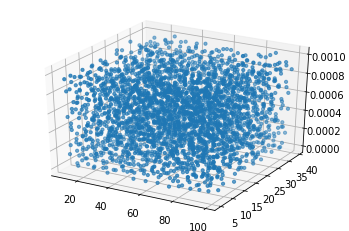

In [37]:
#Visualize pool space

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
pool_array = np.array([np.array(xi) for xi in pool])
ax.scatter(pool_array[:,0].reshape(-1), pool_array[:,1].reshape(-1), pool_array[:,2].reshape(-1), zdir='z', s=10, c=None, depthshade=True)

In [38]:
#Start sampling Vanilla DTTS

while t<Budget:
    print("Exploring")
    for i in range(exploration_count):
        query_index = floor(np.random.random()*(len(pool)-1))
        popped = pool.pop(query_index)
        arms_query.append(popped)
        wins_arm.append(0)
        lose_arm.append(0)
        arms_query_acc.append(0)
        acc = run_config(arms_query[-1])
        arms_query_acc[-1] = acc
        
        binary = binarization(acc)
        wins_arm[-1] += binary
        lose_arm[-1] += 1-binary
        narms+=1
    
    print("Exploiting")
    reward_sample = [np.random.beta(wins_arm[i]+1,lose_arm[i]+1) for i in range(narms)]    
    I_1 = sorted(range(len(reward_sample)), key=lambda i: reward_sample[i])[-exploitation_count:]
    
    if np.random.random() > beta:
        
        reward_sample = [np.random.beta(wins_arm[i]+1,lose_arm[i]+1) for i in range(narms)]    
        I_1 = sorted(range(len(reward_sample)), key=lambda i: reward_sample[i])[-exploitation_count:]
    
    for arm in I_1:
        acc = run_config(arms_query[arm])
        binary = binarization(acc)
        wins_arm[arm] += binary
        lose_arm[arm] += 1-binary
        arms_query_acc[arm] = (arms_query_acc[arm]*(wins_arm[arm]+lose_arm[arm] - 1) + acc) / (wins_arm[arm]+lose_arm[arm]) 

    t+=1
        
        


Exploring
Currently Sampling: [66, 26, 5.470556640624999e-06]
Test acc is: 0.598
Currently Sampling: [50, 15, 0.000604043505859375]
Test acc is: 0.872
Currently Sampling: [93, 30, 0.0007448985595703124]
Test acc is: 0.888
Exploiting
Currently Sampling: [93, 30, 0.0007448985595703124]
Test acc is: 0.878
Currently Sampling: [50, 15, 0.000604043505859375]
Test acc is: 0.8690000000000001
Exploring
Currently Sampling: [14, 23, 0.0009814471679687501]
Test acc is: 0.866
Currently Sampling: [65, 20, 0.0006318727539062499]
Test acc is: 0.8809999999999999
Currently Sampling: [21, 36, 0.0007544190917968749]
Test acc is: 0.8809999999999999
Exploiting
Currently Sampling: [65, 20, 0.0006318727539062499]
Test acc is: 0.88
Currently Sampling: [14, 23, 0.0009814471679687501]
Test acc is: 0.865
Exploring
Currently Sampling: [34, 30, 0.000326727490234375]
Test acc is: 0.852
Currently Sampling: [32, 35, 0.000881359521484375]
Test acc is: 0.89
Currently Sampling: [16, 21, 0.0008535302734374999]
Test acc is

Test acc is: 0.877
Currently Sampling: [93, 23, 0.0008076364257812499]
Test acc is: 0.884
Currently Sampling: [21, 16, 0.00012215810546875]
Test acc is: 0.7170000000000001
Exploiting
Currently Sampling: [21, 36, 0.0007544190917968749]
Test acc is: 0.871
Currently Sampling: [93, 23, 0.0008076364257812499]
Test acc is: 0.884
Exploring
Currently Sampling: [57, 26, 0.0008366862548828125]
Test acc is: 0.887
Currently Sampling: [56, 33, 0.000210528173828125]
Test acc is: 0.801
Currently Sampling: [44, 16, 0.00012606396484375]
Test acc is: 0.72
Exploiting
Currently Sampling: [42, 16, 0.0009194416503906249]
Test acc is: 0.8759999999999999
Currently Sampling: [76, 17, 0.00033112158203125]
Test acc is: 0.833
Exploring
Currently Sampling: [40, 30, 0.00038824477539062496]
Test acc is: 0.867
Currently Sampling: [98, 33, 0.00039141828613281247]
Test acc is: 0.856
Currently Sampling: [13, 20, 0.000656772607421875]
Test acc is: 0.865
Exploiting
Currently Sampling: [50, 15, 0.000604043505859375]
Test a

Test acc is: 0.861
Currently Sampling: [83, 6, 0.0009177328369140625]
Test acc is: 0.884
Exploring
Currently Sampling: [59, 16, 0.0008071481933593749]
Test acc is: 0.877
Currently Sampling: [94, 36, 0.0008786742431640624]
Test acc is: 0.885
Currently Sampling: [72, 7, 0.0008540185058593749]
Test acc is: 0.871
Exploiting
Currently Sampling: [53, 5, 0.0009536179199218749]
Test acc is: 0.88
Currently Sampling: [60, 36, 0.00031940400390624996]
Test acc is: 0.86
Exploring
Currently Sampling: [47, 25, 0.000968264892578125]
Test acc is: 0.882
Currently Sampling: [12, 6, 0.000476126611328125]
Test acc is: 0.856
Currently Sampling: [82, 31, 0.00073147216796875]
Test acc is: 0.884
Exploiting
Currently Sampling: [24, 13, 9.45729736328125e-05]
Test acc is: 0.722
Currently Sampling: [34, 30, 0.000326727490234375]
Test acc is: 0.851
Exploring
Currently Sampling: [76, 38, 0.00016902841796875]
Test acc is: 0.767
Currently Sampling: [88, 36, 0.0008132510986328124]
Test acc is: 0.877
Currently Sampling:

Test acc is: 0.735
Currently Sampling: [38, 12, 0.0004988294189453125]
Test acc is: 0.872
Exploiting
Currently Sampling: [53, 5, 0.0009536179199218749]
Test acc is: 0.877
Currently Sampling: [57, 6, 8.96906494140625e-05]
Test acc is: 0.588
Exploring
Currently Sampling: [40, 28, 3.7693896484375e-05]
Test acc is: 0.653
Currently Sampling: [71, 9, 0.000191487109375]
Test acc is: 0.804
Currently Sampling: [95, 25, 0.0007715072265624999]
Test acc is: 0.8759999999999999
Exploiting
Currently Sampling: [57, 26, 0.0008366862548828125]
Test acc is: 0.88
Currently Sampling: [86, 9, 0.0008471832519531249]
Test acc is: 0.885
Exploring
Currently Sampling: [42, 36, 0.0007312280517578124]
Test acc is: 0.863
Currently Sampling: [28, 19, 0.000386780078125]
Test acc is: 0.86
Currently Sampling: [37, 25, 0.0006816724609374999]
Test acc is: 0.88
Exploiting
Currently Sampling: [47, 25, 0.000968264892578125]
Test acc is: 0.878
Currently Sampling: [37, 23, 0.000306221728515625]
Test acc is: 0.8489999999999999

Test acc is: 0.855
Exploring
Currently Sampling: [55, 17, 0.0008552390869140625]
Test acc is: 0.873
Currently Sampling: [38, 31, 0.0005649849121093749]
Test acc is: 0.8759999999999999
Currently Sampling: [28, 27, 0.0008979594238281249]
Test acc is: 0.875
Exploiting
Currently Sampling: [90, 37, 0.0005825612792968749]
Test acc is: 0.8759999999999999
Currently Sampling: [67, 12, 0.0007099899414062499]
Test acc is: 0.878
Exploring
Currently Sampling: [42, 36, 0.00045317968749999997]
Test acc is: 0.866
Currently Sampling: [59, 37, 0.000858900830078125]
Test acc is: 0.883
Currently Sampling: [69, 31, 0.0005945229736328124]
Test acc is: 0.88
Exploiting
Currently Sampling: [43, 7, 0.0005691348876953124]
Test acc is: 0.8740000000000001
Currently Sampling: [21, 36, 0.0007544190917968749]
Test acc is: 0.867
Exploring
Currently Sampling: [23, 24, 0.0007126752197265624]
Test acc is: 0.873
Currently Sampling: [50, 15, 0.00047759130859375]
Test acc is: 0.866
Currently Sampling: [22, 35, 0.00077028664

In [39]:
def normalized(lr_low,lr_high,nh1_low,nh1_high,nh2_low,nh2_high,inp):
    inp[:,0] = (inp[:,0] - nh1_low)/(nh1_high - nh1_low)
    inp[:,1] = (inp[:,1] - nh2_high)/(nh2_high - nh2_low)
    inp[:,2] = (inp[:,2] - lr_low)/(lr_high - lr_low)
    return inp

In [55]:
np.save("./arms_query1",arms_query)
np.save("./arms_query_acc1",arms_query_acc)
np.save("./pool1",pool)

In [54]:
# Accuracy Predictor
#Train

k = 1.1 ** 2 * RBF(length_scale=0.1) #Check parameters
X = normalized(lr_low,lr_high,nh1_low,nh1_high,nh2_low,nh2_high,np.array(arms_query).reshape(-1,3))
y = np.array(arms_query_acc).reshape(-1,1)
test_X = normalized(lr_low,lr_high,nh1_low,nh1_high,nh2_low,nh2_high,np.array(pool).reshape(-1,3))

gp = GPR(kernel=k, alpha=0.001, optimizer='fmin_l_bfgs_b',normalize_y=False)
gp.fit(X,y)
y_pred, y_std = gp.predict(test_X, return_std=True)
print("Best query arms is {} with accuracy of : {} ".format(arms_query[np.argmax(arms_query_acc)],arms_query_acc[np.argmax(arms_query_acc)]))

print("Best pool arms is {} with accuracy of : {} ".format(pool[np.argmax(y_pred)],y_pred[np.argmax(y_pred),0]))
print(y_pred[:20])

Best query arms is [89, 7, 0.0009792501220703125] with accuracy of : 0.8915000000000001 
Best pool arms is [98, 16, 0.0006443226806640625] with accuracy of : 0.8900269444647151 
[[0.88063876]
 [0.87533663]
 [0.86410845]
 [0.87693581]
 [0.73077507]
 [0.7792263 ]
 [0.88095273]
 [0.86972955]
 [0.87189269]
 [0.83914552]
 [0.88437885]
 [0.70815839]
 [0.8895724 ]
 [0.87289428]
 [0.8491006 ]
 [0.87057699]
 [0.78381312]
 [0.75394435]
 [0.88221765]
 [0.87521997]]


In [42]:
run_config(arms_query[np.argmax(arms_query_acc)],epochs = 50)
run_config(pool[np.argmax(y_pred)],epochs = 50)


Currently Sampling: [89, 7, 0.0009792501220703125]
Test acc is: 0.89
Currently Sampling: [98, 16, 0.0006443226806640625]
Test acc is: 0.8909999999999999


0.8909999999999999

In [48]:

y_actual = []
for i in pool[:20]:
    y_actual.append(run_config(i))
print(y_actual)
    

Currently Sampling: [55, 22, 0.0005000499999999999]
Test acc is: 0.872
Currently Sampling: [32, 31, 0.000750025]
Test acc is: 0.879
Currently Sampling: [43, 26, 0.0003750625]
Test acc is: 0.856
Currently Sampling: [21, 18, 0.0006250374999999999]
Test acc is: 0.878
Currently Sampling: [66, 35, 0.0001250875]
Test acc is: 0.726
Currently Sampling: [38, 15, 0.00018758125]
Test acc is: 0.799
Currently Sampling: [83, 33, 0.0006875312499999999]
Test acc is: 0.8909999999999999
Currently Sampling: [15, 24, 0.0009375062499999999]
Test acc is: 0.8740000000000001
Currently Sampling: [60, 7, 0.00043755625]
Test acc is: 0.867
Currently Sampling: [26, 37, 0.00031256875]
Test acc is: 0.85
Currently Sampling: [49, 11, 0.0005625437499999999]
Test acc is: 0.8759999999999999
Currently Sampling: [52, 34, 9.3840625e-05]
Test acc is: 0.727
Currently Sampling: [97, 17, 0.000593790625]
Test acc is: 0.885
Currently Sampling: [29, 8, 0.0008437656249999999]
Test acc is: 0.867
Currently Sampling: [74, 25, 0.000343

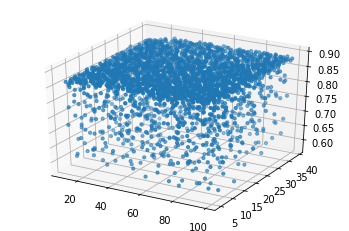

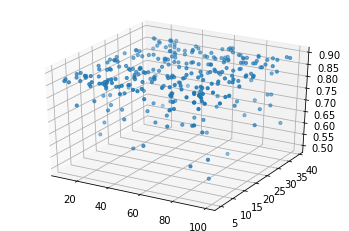

In [44]:
#Visualize

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
pool_array = np.array([np.array(xi) for xi in pool])
ax.scatter(pool_array[:,0].reshape(-1), pool_array[:,1].reshape(-1), y_pred, zdir='z', s=10, c=None, depthshade=True)        
        

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
arms_query_array = np.array([np.array(xi) for xi in arms_query])
ax.scatter(arms_query_array[:,0].reshape(-1), arms_query_array[:,1].reshape(-1), arms_query_acc, zdir='z', s=10, c=None, depthshade=True)

In [56]:
#Define ranges, exploitation, exploration and pool space for second approach
t = 0
Budget = 150
lr_low = 1e-7
lr_high = 1e-3
nh1_low = 10
nh1_high = 100
nh2_low = 5
nh2_high = 40

exploitation_count = 2
exploration_count = 3
pool_count = 3000
seq = sobol_seq.i4_sobol_generate(3,pool_count)
pool = [query(lr_low,lr_high,nh1_low,nh1_high,nh2_low,nh2_high,sobol) for sobol in seq]

arms_query = []
arms_query_acc = []
beta = 0.9

narms = 0
wins_arm = []
lose_arm = []



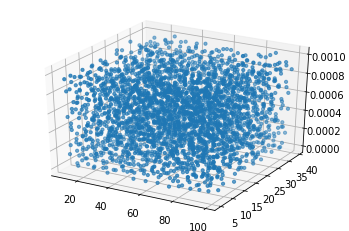

In [57]:
#Visualize pool space

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
pool_array = np.array([np.array(xi) for xi in pool])
ax.scatter(pool_array[:,0].reshape(-1), pool_array[:,1].reshape(-1), pool_array[:,2].reshape(-1), zdir='z', s=10, c=None, depthshade=True)

In [59]:
      
def variance_pred(X,y,test_X):
    k = 1.1 ** 2 * RBF(length_scale=0.1) #Check parameters
    gp = GPR(kernel=k, alpha=0.001, optimizer='fmin_l_bfgs_b',normalize_y=False)
    gp.fit(X,y)
    y_pred, y_std = gp.predict(test_X, return_std=True)
    return y_std

In [60]:
#With Predictor in the loop

while t<Budget:
    print("Exploring")
    if t== 0 :
        for i in range(exploration_count):
            query_index = floor(np.random.random()*(len(pool)-1))
            popped = pool.pop(query_index)
            arms_query.append(popped)
            wins_arm.append(0)
            lose_arm.append(0)
            arms_query_acc.append(0)
            acc = run_config(arms_query[-1])
            arms_query_acc[-1] = acc

            binary = binarization(acc)
            wins_arm[-1] += binary
            lose_arm[-1] += 1-binary
            narms+=1
    else:
        X = normalized(lr_low,lr_high,nh1_low,nh1_high,nh2_low,nh2_high,np.array(arms_query).reshape(-1,3))
        y = np.array(arms_query_acc).reshape(-1,1)
        test_X = normalized(lr_low,lr_high,nh1_low,nh1_high,nh2_low,nh2_high,np.array(pool).reshape(-1,3))
        var = variance_pred(X,y,test_X)
        exp = sorted(range(len(var)), key=lambda i: var[i])[-exploration_count:]
        
        for arms in exp:
            popped = pool.pop(arms)
            arms_query.append(popped)
            wins_arm.append(0)
            lose_arm.append(0)
            arms_query_acc.append(0)
            acc = run_config(arms_query[-1])
            arms_query_acc[-1] = acc
            binary = binarization(acc)
            wins_arm[-1] += binary
            lose_arm[-1] += 1-binary
            narms+=1
            
        
    
    print("Exploiting")
    reward_sample = [np.random.beta(wins_arm[i]+1,lose_arm[i]+1) for i in range(narms)]    
    I_1 = sorted(range(len(reward_sample)), key=lambda i: reward_sample[i])[-exploitation_count:]
    
    if np.random.random() > beta:
        
        reward_sample = [np.random.beta(wins_arm[i]+1,lose_arm[i]+1) for i in range(narms)]    
        I_1 = sorted(range(len(reward_sample)), key=lambda i: reward_sample[i])[-exploitation_count:]
    
    for arm in I_1:
        acc = run_config(arms_query[arm])
        binary = binarization(acc)
        wins_arm[arm] += binary
        lose_arm[arm] += 1-binary
        arms_query_acc[arm] = (arms_query_acc[arm]*(wins_arm[arm]+lose_arm[arm] - 1) + acc) / (wins_arm[arm]+lose_arm[arm]) 

    t+=1

        
    


Exploring
Currently Sampling: [60, 23, 0.0001189845947265625]
Test acc is: 0.715
Currently Sampling: [79, 28, 0.00033771271972656247]
Test acc is: 0.857
Currently Sampling: [91, 33, 0.0009626502197265624]
Test acc is: 0.8740000000000001
Exploiting
Currently Sampling: [91, 33, 0.0009626502197265624]
Test acc is: 0.879
Currently Sampling: [81, 27, 0.0009567914306640624]
Test acc is: 0.883
Exploring
Currently Sampling: [14, 7, 0.0009558149658203124]
Test acc is: 0.884
Currently Sampling: [60, 22, 0.0004998058837890624]
Test acc is: 0.88
Currently Sampling: [11, 5, 0.00095215322265625]
Test acc is: 0.875
Exploiting
Currently Sampling: [60, 22, 0.0004998058837890624]
Test acc is: 0.8759999999999999
Currently Sampling: [79, 28, 0.00033771271972656247]
Test acc is: 0.852
Exploring
Currently Sampling: [91, 6, 3.6961547851562504e-05]
Test acc is: 0.7019999999999998
Currently Sampling: [98, 9, 8.6440673828125e-06]
Test acc is: 0.498
Currently Sampling: [95, 7, 2.060576171875e-05]
Test acc is: 0.

Test acc is: 0.882
Currently Sampling: [10, 19, 0.0005020029296874999]
Test acc is: 0.861
Exploiting
Currently Sampling: [51, 25, 0.0008259451416015624]
Test acc is: 0.882
Currently Sampling: [98, 5, 0.0003281921875]
Test acc is: 0.8539999999999999
Exploring
Currently Sampling: [96, 39, 0.0007138958007812499]
Test acc is: 0.885
Currently Sampling: [31, 30, 0.0008686654785156249]
Test acc is: 0.8690000000000001
Currently Sampling: [96, 7, 0.0003259951416015625]
Test acc is: 0.862
Exploiting
Currently Sampling: [13, 7, 2.91498291015625e-05]
Test acc is: 0.522
Currently Sampling: [79, 28, 0.00033771271972656247]
Test acc is: 0.861
Exploring
Currently Sampling: [44, 39, 0.00037408603515624996]
Test acc is: 0.8590000000000001
Currently Sampling: [96, 22, 0.0008278980712890624]
Test acc is: 0.8759999999999999
Currently Sampling: [22, 8, 0.00029011005859374997]
Test acc is: 0.848
Exploiting
Currently Sampling: [15, 5, 0.0009997558837890625]
Test acc is: 0.861
Currently Sampling: [98, 5, 0.000

Test acc is: 0.662
Currently Sampling: [77, 29, 1.07646484375e-06]
Test acc is: 0.6579999999999999
Currently Sampling: [21, 21, 7.423486328125e-06]
Test acc is: 0.574
Exploiting
Currently Sampling: [12, 18, 0.0009741236816406249]
Test acc is: 0.8590000000000001
Currently Sampling: [35, 33, 0.0007790748291015624]
Test acc is: 0.863
Exploring
Currently Sampling: [97, 5, 0.0002254192626953125]
Test acc is: 0.828
Currently Sampling: [98, 34, 0.0009890147705078126]
Test acc is: 0.884
Currently Sampling: [16, 37, 0.000979006005859375]
Test acc is: 0.867
Exploiting
Currently Sampling: [98, 37, 0.0009555708496093749]
Test acc is: 0.885
Currently Sampling: [14, 7, 0.0009558149658203124]
Test acc is: 0.8809999999999999
Exploring
Currently Sampling: [99, 27, 0.0006313845214843749]
Test acc is: 0.868
Currently Sampling: [31, 38, 0.0008064158447265625]
Test acc is: 0.8740000000000001
Currently Sampling: [32, 15, 0.0006177140136718749]
Test acc is: 0.8759999999999999
Exploiting
Currently Sampling: [

Test acc is: 0.866
Currently Sampling: [96, 15, 0.0004246180908203125]
Test acc is: 0.86
Exploring
Currently Sampling: [99, 16, 0.0008823359863281249]
Test acc is: 0.883
Currently Sampling: [29, 34, 0.0007243927978515624]
Test acc is: 0.883
Currently Sampling: [73, 30, 7.79730712890625e-05]
Test acc is: 0.705
Exploiting
Currently Sampling: [38, 17, 0.0009968264892578126]
Test acc is: 0.8859999999999999
Currently Sampling: [28, 23, 0.000764183740234375]
Test acc is: 0.875
Exploring
Currently Sampling: [27, 5, 6.357021484375e-05]
Test acc is: 0.715
Currently Sampling: [51, 6, 7.69966064453125e-05]
Test acc is: 0.713
Currently Sampling: [76, 16, 0.0006091699462890624]
Test acc is: 0.877
Exploiting
Currently Sampling: [73, 5, 0.0009587443603515624]
Test acc is: 0.885
Currently Sampling: [55, 7, 0.0005622996337890624]
Test acc is: 0.8740000000000001
Exploring
Currently Sampling: [11, 6, 0.0002381133056640625]
Test acc is: 0.792
Currently Sampling: [99, 18, 0.0001082434814453125]
Test acc is

Test acc is: 0.878
Exploring
Currently Sampling: [10, 35, 0.0003552890869140625]
Test acc is: 0.8439999999999999
Currently Sampling: [95, 5, 0.000486867724609375]
Test acc is: 0.878
Currently Sampling: [19, 6, 0.00036505373535156247]
Test acc is: 0.8590000000000001
Exploiting
Currently Sampling: [11, 37, 0.0008972270751953124]
Test acc is: 0.871
Currently Sampling: [36, 17, 0.0004275474853515625]
Test acc is: 0.8640000000000001
Exploring
Currently Sampling: [78, 20, 0.00099707060546875]
Test acc is: 0.8759999999999999
Currently Sampling: [59, 22, 0.00035699790039062497]
Test acc is: 0.848
Currently Sampling: [64, 24, 0.0008650037353515625]
Test acc is: 0.87
Exploiting
Currently Sampling: [12, 10, 0.0009118740478515625]
Test acc is: 0.87
Currently Sampling: [81, 26, 0.000258374951171875]
Test acc is: 0.839
Exploring
Currently Sampling: [77, 7, 6.93525390625e-06]
Test acc is: 0.498
Currently Sampling: [25, 18, 0.000481985400390625]
Test acc is: 0.86
Currently Sampling: [42, 33, 0.0006150

Test acc is: 0.879
Currently Sampling: [47, 29, 0.0004041123291015625]
Test acc is: 0.853
Exploiting
Currently Sampling: [12, 18, 0.0009741236816406249]
Test acc is: 0.86
Currently Sampling: [31, 32, 0.0007422132812499999]
Test acc is: 0.8740000000000001
Exploring
Currently Sampling: [10, 11, 0.0007470956054687499]
Test acc is: 0.8690000000000001
Currently Sampling: [34, 11, 0.0008376627197265624]
Test acc is: 0.87
Currently Sampling: [92, 11, 0.0009040623291015624]
Test acc is: 0.8740000000000001
Exploiting
Currently Sampling: [17, 5, 4.77026611328125e-05]
Test acc is: 0.6730000000000002
Currently Sampling: [27, 14, 0.0005408174072265624]
Test acc is: 0.866
Exploring
Currently Sampling: [21, 5, 0.0009362856689453124]
Test acc is: 0.871
Currently Sampling: [46, 15, 0.0004627002197265625]
Test acc is: 0.8690000000000001
Currently Sampling: [24, 20, 0.0006540873291015624]
Test acc is: 0.8740000000000001
Exploiting
Currently Sampling: [26, 19, 0.0002439720947265625]
Test acc is: 0.838
Cur

IndexError: pop index out of range

In [61]:
np.save("./arms_query2",arms_query)
np.save("./arms_query_acc2",arms_query_acc)
np.save("./pool2",pool)

In [62]:
# Accuracy Predictor
#Train

k = 1.1 ** 2 * RBF(length_scale=0.1) #Check parameters
X = normalized(lr_low,lr_high,nh1_low,nh1_high,nh2_low,nh2_high,np.array(arms_query).reshape(-1,3))
y = np.array(arms_query_acc).reshape(-1,1)
test_X = normalized(lr_low,lr_high,nh1_low,nh1_high,nh2_low,nh2_high,np.array(pool).reshape(-1,3))

gp = GPR(kernel=k, alpha=0.001, optimizer='fmin_l_bfgs_b',normalize_y=False)
gp.fit(X,y)
y_pred, y_std = gp.predict(test_X, return_std=True)
print("Best query arms is {} with accuracy of : {} ".format(arms_query[np.argmax(arms_query_acc)],arms_query_acc[np.argmax(arms_query_acc)]))

print("Best pool arms is {} with accuracy of : {} ".format(pool[np.argmax(y_pred)],y_pred[np.argmax(y_pred),0]))
print(y_pred[:20])

Best query arms is [99, 38, 0.0006186904785156249] with accuracy of : 0.89 
Best pool arms is [55, 11, 0.0009980470703125] with accuracy of : 0.8907150803341324 
[[0.88251992]
 [0.86850887]
 [0.81906533]
 [0.86975068]
 [0.87519623]
 [0.87311333]
 [0.71345107]
 [0.77003551]
 [0.87523358]
 [0.86931119]
 [0.87224649]
 [0.84924462]
 [0.86570971]
 [0.88118001]
 [0.63791818]
 [0.67903662]
 [0.88122876]
 [0.86983459]
 [0.86377156]
 [0.87501779]]


In [63]:
y_actual = []
for i in pool[:20]:
    y_actual.append(run_config(i))
print(y_actual)

Currently Sampling: [55, 22, 0.0005000499999999999]
Test acc is: 0.863
Currently Sampling: [32, 31, 0.000750025]
Test acc is: 0.8759999999999999
Currently Sampling: [77, 13, 0.000250075]
Test acc is: 0.8219999999999998
Currently Sampling: [43, 26, 0.0003750625]
Test acc is: 0.857
Currently Sampling: [88, 9, 0.0008750124999999999]
Test acc is: 0.8809999999999999
Currently Sampling: [21, 18, 0.0006250374999999999]
Test acc is: 0.87
Currently Sampling: [66, 35, 0.0001250875]
Test acc is: 0.716
Currently Sampling: [38, 15, 0.00018758125]
Test acc is: 0.794
Currently Sampling: [83, 33, 0.0006875312499999999]
Test acc is: 0.89
Currently Sampling: [15, 24, 0.0009375062499999999]
Test acc is: 0.8640000000000001
Currently Sampling: [60, 7, 0.00043755625]
Test acc is: 0.868
Currently Sampling: [26, 37, 0.00031256875]
Test acc is: 0.846
Currently Sampling: [71, 20, 0.00081251875]
Test acc is: 0.879
Currently Sampling: [49, 11, 0.0005625437499999999]
Test acc is: 0.877
Currently Sampling: [94, 29,

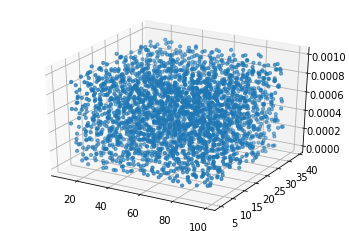

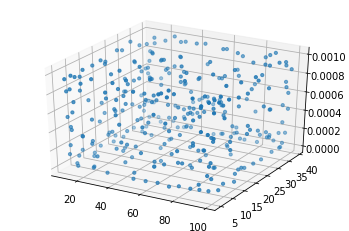

In [69]:
#Visualize

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
pool_array = np.array([np.array(xi) for xi in pool])
ax.scatter(pool_array[:,0].reshape(-1), pool_array[:,1].reshape(-1),pool_array[:,2].reshape(-1), zdir='z', s=10, c=None, depthshade=True)        
        

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
arms_query_array = np.array([np.array(xi) for xi in arms_query])
ax.scatter(arms_query_array[:,0].reshape(-1), arms_query_array[:,1].reshape(-1),  arms_query_array[:,2].reshape(-1), zdir='z', s=10, c=None, depthshade=True)

In [65]:
run_config(arms_query[np.argmax(arms_query_acc)],epochs = 50)
run_config(pool[np.argmax(y_pred)],epochs = 50)

Currently Sampling: [99, 38, 0.0006186904785156249]
Test acc is: 0.882
Currently Sampling: [55, 11, 0.0009980470703125]
Test acc is: 0.892


0.892